# Notebook for visualizing streaming data

In [1]:
import fastplotlib as fpl 
import numpy as np
import zmq
import tifffile
import scipy
import queue

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


Image(value=b'version https://git-lfs.github.com/spec/...', height='55', width='300')

Valid,Device,Type,Backend,Driver
✅,Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,Vulkan,Mesa 25.0.4
✅ (default),NVIDIA GeForce RTX 4060 Laptop GPU,DiscreteGPU,Vulkan,565.77
❗ limited,"llvmpipe (LLVM 19.1.7, 256 bits)",CPU,Vulkan,Mesa 25.0.4 (LLVM 19.1.7)
❌,Mesa Intel(R) Arc(tm) Graphics (MTL),IntegratedGPU,OpenGL,4.6 (Core Profile) Mesa 25.0.4


Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.


# Calculate seeded median

In [2]:
file_path = "/home/clewis/repos/holo-nbs/rb26_20240111/raw_voltage_chunk.tif"
data = tifffile.memmap(file_path)
data.shape

(384, 3000001)

In [3]:
# define filter functions
def butter(cutoff, fs, order=5, btype='high'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a


def butter_filter(data, cutoff, fs, order=5, axis=-1, btype='high'):
    b, a = butter(cutoff, fs, order=order, btype=btype)
    y = scipy.signal.filtfilt(b, a, data, axis=axis)
    return y

In [4]:
median = np.median(butter_filter(data[:, :4000], 1_000, 30_000), axis=1)

# Create queue for viz data

In [5]:
viz_queue = queue.Queue(maxsize=100)

# Setup zmq subscriber

In [6]:
context = zmq.Context()
sub = context.socket(zmq.SUB)
sub.setsockopt(zmq.SUBSCRIBE, b"")

# keep only the most recent message
sub.setsockopt(zmq.CONFLATE, 1)

# address must match publisher in actor
sub.connect("tcp://127.0.0.1:5557")

<SocketContext(connect='tcp://127.0.0.1:5557')>

In [7]:
def get_buffer():
    """Gets the buffer from the publisher."""
    try:
        b = sub.recv(zmq.NOBLOCK)
    except zmq.Again:
        pass
    else:
        return b
    
    return None

# Helper functions

In [8]:
def get_spike_events(data: np.ndarray, n_deviations: int = 4):
    """
    Calculates the median and MAD estimator. Returns a list of indices along each channel where
    threshold crossing is made (above absolute value of median + (n_deviations * MAD).
    """
    global median
    # median = np.median(data, axis=1)
    mad = scipy.stats.median_abs_deviation(data, axis=1)

    thresh = (n_deviations * mad) + median

    abs_data = np.abs(data)

    # Find indices where threshold is crossed for each channel
    indices = [np.where(abs_data[i] > thresh[i])[0] for i in range(data.shape[0])]

    return indices

In [9]:
def make_raster(ixs):
    """
    Takes a list of threshold crossings and returns a list of points (channel number, spike time) and colors.
    Used to make a raster plot.
    """
    spikes = list()

    for i, ix in enumerate(ixs):
        ys = np.full(ix.shape, i * 2)
        sp = np.vstack([ix, ys]).T
        spikes.append(sp)

    colors = list()

    for i in spikes:
        # randomly select a color
        c = [np.append(np.random.rand(3), 1)] * len(i)
        colors += c

    return spikes, np.array(colors)

# Create figure

In [10]:
rects = [
    (0, 0, 0.5, 1),  # for image1
    (0.5, 0, 0.5, 1),  # for image2
]

figure = fpl.Figure(rects=rects, size=(1000, 900), names=["filtered spikes", "raster"])

for subplot in figure:
    subplot.axes.visible = False
    subplot.camera.maintain_aspect = False

RFBOutputContext()

Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
Draw error
Traceback (most recent call last):
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/rendercanvas/_coreutils.py", line 41, in log_exception
    yield
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/rendercanvas/base.py", line 456, in _draw_frame_and_present
    self._draw_frame()
  File "/home/clewis/repos/fastplotlib/fastplotlib/layouts/_imgui_figure.py", line 125, in _render
    self.imgui_renderer.render()
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/utils/imgui/imgui_renderer.py", line 168, in render
    render_pass.end()
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/backends/wgpu_native/_api.py", line 3509, in end
    libf.wgpuRenderPassEncoderEnd(self._internal)
  File "/home/clewis/venvs/bah/lib64/python3.11/site-packages/wgpu/backends/wgpu_native/_helpers.py", line 457, in proxy_func
    raise wg

In [11]:
def update():
    """Function to actual update the figure."""
    global viz_queue
    global figure

    data = viz_queue.get()
    
    ixs = get_spike_events(data)

    spikes, colors = make_raster(ixs)
    spikes = np.concatenate(spikes)


    if len(figure["filtered spikes"].graphics) == 0:
        lg = figure["filtered spikes"].add_line_stack(data, colors="gray", thickness=0.5, separation=35, name="lg")
    else:
        lg = figure["filtered spikes"]["lg"]
        lg.colors = "gray"
        # add filtered spikes
        for i in range(lg.data[:].shape[0]):
            lg[i].data[:, 1] = data[i]

    # color each spike event orange
    for i in range(len(ixs)):
        if ixs[i].shape[0] == 0:
            continue
            
        lg[i].colors[ixs[i]] = "orange"

    figure["raster"].clear()

    # make raster 
    figure["raster"].add_scatter(spikes, sizes=5, colors=colors)

    for subplot in figure:
        subplot.auto_scale()

In [12]:
def update_figure(p):
    """Fetch the data from the socket, deserialize it, and put it in the queue for visualization."""
    global viz_queue
    
    buff = get_buffer()
    if buff is not None:
        # Deserialize the buffer into a NumPy array
        data = np.frombuffer(buff, dtype=np.float64)

        data = data.reshape(384, 150)

        viz_queue.put(data)

        if viz_queue.qsize() % 5 == 0:
            update()

JupyterRenderCanvas(css_height='900.0px', css_width='1000.0px')
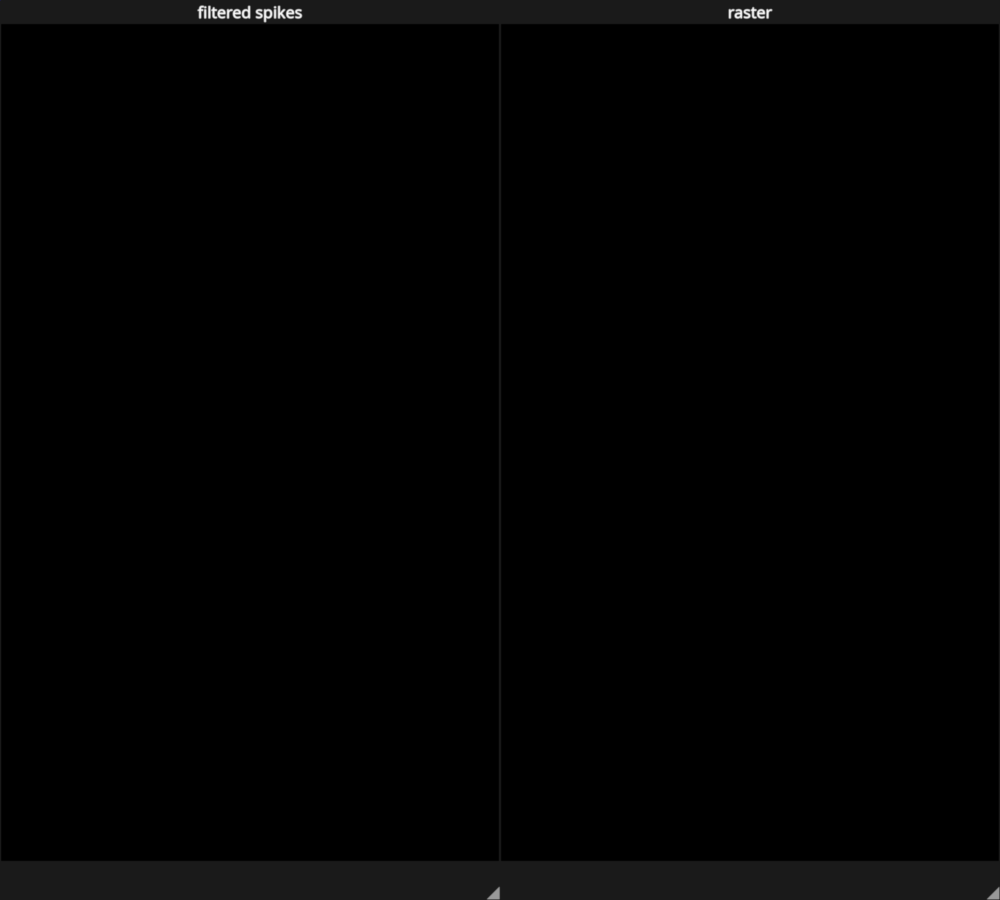

In [13]:
figure.show()

In [14]:
# Add the animation update function
figure.add_animations(update_figure)